In [1]:
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import ndimage

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

%matplotlib inline

/home/wtgee/anaconda3/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
from astropy.stats import sigma_clipped_stats
from photutils import find_peaks

In [3]:
from astropy.utils.data import get_file_contents

In [4]:
def get_peaks(data, plot=False):
    mean, median, std = sigma_clipped_stats(data, sigma=5.0)
    threshold = median + (10.0 * std)

    tbl = find_peaks(data, threshold, min_separation=10, exclude_border=True)

    if plot:
        norm = ImageNormalize(stretch=SqrtStretch())
        plt.imshow(data, cmap='Greys_r', origin='lower', norm=norm)
        plt.plot(tbl[:,1], tbl[:,0], ls='none', color='cyan', marker='x', ms=5, lw=1.5)
        plt.xlim(0, data.shape[1]-1)
        plt.ylim(0, data.shape[0]-1)
    
    return tbl

In [5]:
def nearby(test_list_0, test_list_1, delta=5):
    same_target = list()
    
    for x0, y0 in test_list_0:
        for x1, y1 in test_list_1:
            if abs(x0 - x1) < delta:
                if abs(y0 - y1) < delta:
                    same_target.append((x1-x0, y1-y0))
        
    return np.array(same_target)

In [10]:
def compare_images(fits_0, fits_1, box_width=200):
    image_dir = '/var/panoptes/images/20150906/'
    img_1 = fits.open(image_dir + fits_0)
    img_2 = fits.open(image_dir + fits_1)
    
    image_data_01 = img_1[0].data
    image_data_02 = img_2[0].data    
    
    img_1.close()
    img_2.close()    
    
    # Green channel
    green_data_01 = image_data_01[1]
    green_data_02 = image_data_02[1]    
    
    # Get the center
    x_len, y_len = green_data_01.shape
    x_center = int(x_len / 2)
    y_center = int(y_len / 2)    
    
    box_width = box_width / 2
    center_01 = green_data_01[x_center-box_width:x_center+box_width, y_center-box_width:y_center+box_width]
    center_02 = green_data_02[x_center-box_width:x_center+box_width, y_center-box_width:y_center+box_width]
    
    # norm = ImageNormalize(stretch=SqrtStretch())
    
    # plt.imshow(center_01, cmap='Greys_r', origin='lower', norm=norm)  
    # plt.imshow(center_02, cmap='Greys_r', origin='lower', norm=norm)    
    
    peaks_01 = get_peaks(center_01, plot=True)    
    peaks_02 = get_peaks(center_02)    
    
    same_target = nearby(peaks_01, peaks_02)    
    
    y_mean = same_target[:,1].mean()
    x_mean = same_target[:,0].mean()
    return (x_mean, y_mean)    

/home/wtgee/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/wtgee/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0.0, -1.8529411764705883)

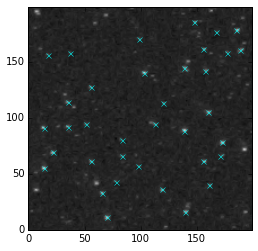

In [11]:
compare_images('01_127.fits', '01_130.fits')

In [17]:
!/var/panoptes/bin/measure_offset /var/panoptes/images/20150906/01_127.cr2 /var/panoptes/images/20150906/01_130.cr2

type "help" for instructions
Running with openMP, max threads = 8  (defined by environment variable OMP_NUM_THREADS)
RAND: 530614464193648
196 commands loaded
cfits > RGBfullres=1
	 double: 1
cfits > loadcr2torgb "/var/panoptes/images/20150906/01_127.cr2" im0r im0g im0b
Unprocessed string : /var/panoptes/images/20150906/01_127.cr2
PGM image size: 5208 x 3476
Reading PGM image
FLUXFACTOR = 1
X Y  = 5208 3476
FAST MODE = 0
RGBmode   = 1
14 hot pixels removed
cfits > loadcr2torgb "/var/panoptes/images/20150906/01_130.cr2" im1r im1g im1b
Unprocessed string : /var/panoptes/images/20150906/01_130.cr2
PGM image size: 5208 x 3476
Reading PGM image
FLUXFACTOR = 1
X Y  = 5208 3476
FAST MODE = 0
RGBmode   = 1
13 hot pixels removed
cfits > #savefits im0g "!im0g.fits"
cfits > #savefits im1g "!im1g.fits"
cfits > fcorrel im0g im1g imcg
IMAGE IMAGE -> IMAGE
IMAGE IMAGE -> IMAGE
cfits > extractim imcg imcge 200 200 2504 1638
	 long:   200
	 long:   200
	 long:   2504
	 long:   1638
CROP: 
axis 0: 2504 

In [ ]:
x_cent = float(get_file_contents('xcent.txt'))
y_cent = float(get_file_contents('ycent.txt'))
print(x_cent, y_cent)